# ICU Survival

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import precision_score, recall_score

%matplotlib inline

In [2]:
%%bash
ls data

Outcomes-a.txt
PhysioNet_Computing in_Cardiology_Challenge_2012.pdf
Reference.txt
seta_data.csv


## Exploratory Data Analysis

Initial Questions I had before starting:

- What is the more common outcome? Survival or death?
- What are the general ranges of each field?
- Which fields are most predictive of the outcome?
- When does missingness happen?
- Does missingness tell us inform us about the probability of survival? Or is it missing completely at random?
- Is there a subtype of people that the model is doing poorly on? Is there something in common among people that are mislabeled?
- Does the length of time tell us something about the measurements tell us something about survival?
- Should we see the times?
- What are the "normal" ranges for variable, given the literature? How much does an individual stay in (or outside) the "normal" range? given the 48 hours???



### load data

In [3]:
seta_data = pd.read_csv('data/seta_data.csv')
seta_data.head(5)

,PATIENT_ID,Parameter,Time,Value
0,132539,RecordID,00:00,132539.0
1,132539,Age,00:00,54.0
2,132539,Gender,00:00,0.0
3,132539,Height,00:00,-1.0
4,132539,ICUType,00:00,4.0


In [4]:
outcomes = pd.read_csv('data/Outcomes-a.txt')

In [5]:
outcomes.head(5)

,RecordID,SAPS-I,SOFA,Length_of_stay,Survival,In-hospital_death
0,132539,6,1,5,-1,0
1,132540,16,8,8,-1,0
2,132541,21,11,19,-1,0
3,132543,7,1,9,575,0
4,132545,17,2,4,918,0


### number of survivals

In [6]:
num_survivals = outcomes.groupby('In-hospital_death').count()['Survival']

In [7]:
num_survivals

In-hospital_death
0    3446
1     554
Name: Survival, dtype: int64

In [8]:
in_hospital_death_outcomes = outcomes[outcomes['In-hospital_death'] == 1]
not_in_hospital_death_outcomes = outcomes[outcomes['In-hospital_death'] == 0]

In [9]:
print(str(num_survivals[0] / (num_survivals[0] + num_survivals[1])) + ' of the sample survive.')

0.8615 of the sample survive.


In [10]:
seta_data.columns

Index(['PATIENT_ID', 'Parameter', 'Time', 'Value'], dtype='object')

In [11]:
unique_patient_ids = seta_data['PATIENT_ID'].unique()
unique_patient_ids.shape

(4000,)

We could compare the values of those who did survive vs those who didn't survive, for each category. See if there are any patterns.

When there's a "-1", maybe we could just skip it?

Prior knowledge: 

1. People are more likely to die if their measurements are too high or too low (i.e. not normal).
2. Huge variability of measurements within an individual could indicate severity of a problem. Severity obviously influences mortality.
3. Where they end up affects the types of measurements that are collected, which might give us information about severity.

We could maybe find the optimal number of samples. Then we could take the average (or some statistic) of that certain section so we have a standardized data set.

In [12]:
{
    'HR': [60, 100] # https://www.mayoclinic.org/healthy-lifestyle/fitness/expert-answers/heart-rate/faq-20057979
    
}

{'HR': [60, 100]}

In [13]:
unique_parameters = seta_data['Parameter'].unique()
params_without_record_id = list(set(unique_parameters) - set(['RecordID']))

In [14]:
in_hospital_death_data = seta_data[seta_data.index.isin(in_hospital_death_outcomes['RecordID'])]
not_in_hospital_death_data = seta_data[seta_data.index.isin(not_in_hospital_death_outcomes['RecordID'])]

### set time string to timedelta

In [15]:
seta_data['Time_delta'] = pd.to_timedelta(seta_data['Time'] + ':00', 'hours')
seta_data['Time_delta'].tail(5)

1757975   1 days 23:36:00
1757976   1 days 23:36:00
1757977   1 days 23:36:00
1757978   1 days 23:36:00
1757979   1 days 23:36:00
Name: Time_delta, dtype: timedelta64[ns]

### Discretize Time into X-hour blocks

Why 3 hours? Well, there are 16 3-hour blocks in 48 hours. 16 * 40 variables is 640, which is less than 4000, so $n$ > $p$. $n$ < $p$ is a bad place to be, as we can have an infinite number of solutions.

In [16]:
WIDTH_HOURS=12

In [17]:
def bin_time(df, width_hours=3, num_hours=48, timedelta_col='Time_delta'):
    for i in range(int(num_hours / width_hours)):
        start = i * width_hours
        end = start + width_hours
        start_string = str(start) + ' hours'
        end_string = str(end) + ' hours'
        
        start_timedelta = pd.to_timedelta(start_string)
        end_timedelta = pd.to_timedelta(end_string)
        
        mask = (df[timedelta_col] >= start_timedelta) & (df[timedelta_col] < end_timedelta)
        
        df.loc[mask, 'time_block'] = start

In [18]:
bin_time(seta_data, width_hours=WIDTH_HOURS)

In [19]:
seta_data

,PATIENT_ID,Parameter,Time,Value,Time_delta,time_block
0,132539,RecordID,00:00,132539.00,0 days 00:00:00,0.0
1,132539,Age,00:00,54.00,0 days 00:00:00,0.0
2,132539,Gender,00:00,0.00,0 days 00:00:00,0.0
3,132539,Height,00:00,-1.00,0 days 00:00:00,0.0
4,132539,ICUType,00:00,4.00,0 days 00:00:00,0.0
5,132539,Weight,00:00,-1.00,0 days 00:00:00,0.0
6,132539,GCS,00:07,15.00,0 days 00:07:00,0.0
7,132539,HR,00:07,73.00,0 days 00:07:00,0.0
8,132539,NIDiasABP,00:07,65.00,0 days 00:07:00,0.0
9,132539,NIMAP,00:07,92.33,0 days 00:07:00,0.0


### Convert -1 to NaN

Convert -1 to None so when we take aggregates, we don't make it seem that missing is basically almost the same as 0.

In [20]:
seta_data.replace(to_replace=-1, value=np.NaN, inplace=True)

In [21]:
averaged = seta_data.groupby(['PATIENT_ID', 'Parameter', 'time_block']).mean()

In [22]:
reset_averaged = averaged.reset_index()

In [23]:
reset_averaged

,PATIENT_ID,Parameter,time_block,Value
0,132539,Age,0.0,54.000000
1,132539,BUN,0.0,13.000000
2,132539,BUN,24.0,8.000000
3,132539,Creatinine,0.0,0.800000
4,132539,Creatinine,24.0,0.700000
5,132539,GCS,0.0,15.000000
6,132539,GCS,12.0,15.000000
7,132539,GCS,24.0,14.666667
8,132539,GCS,36.0,15.000000
9,132539,Gender,0.0,0.000000


In [24]:
standardizable_vars = list(set(params_without_record_id) - set([
    'ICUType', # categorical
    'Gender',  # dichotomous,
    'MechVent', # useless; same value across all individuals
]))
standardizable_vars

['Bilirubin',
 'Height',
 'SysABP',
 'HCT',
 'AST',
 'TroponinI',
 'Albumin',
 'PaO2',
 'Creatinine',
 'HR',
 'ALP',
 'Temp',
 'pH',
 'FiO2',
 'Platelets',
 'ALT',
 'Urine',
 'BUN',
 'HCO3',
 'K',
 'Mg',
 'Na',
 'NISysABP',
 'GCS',
 'TroponinT',
 'RespRate',
 'Lactate',
 'Age',
 'Weight',
 'DiasABP',
 'Cholesterol',
 'Glucose',
 'NIDiasABP',
 'PaCO2',
 'MAP',
 'NIMAP',
 'SaO2',
 'WBC']

In [25]:
unique_patient_ids.shape

(4000,)

### Univariate KDE of standardizable variables

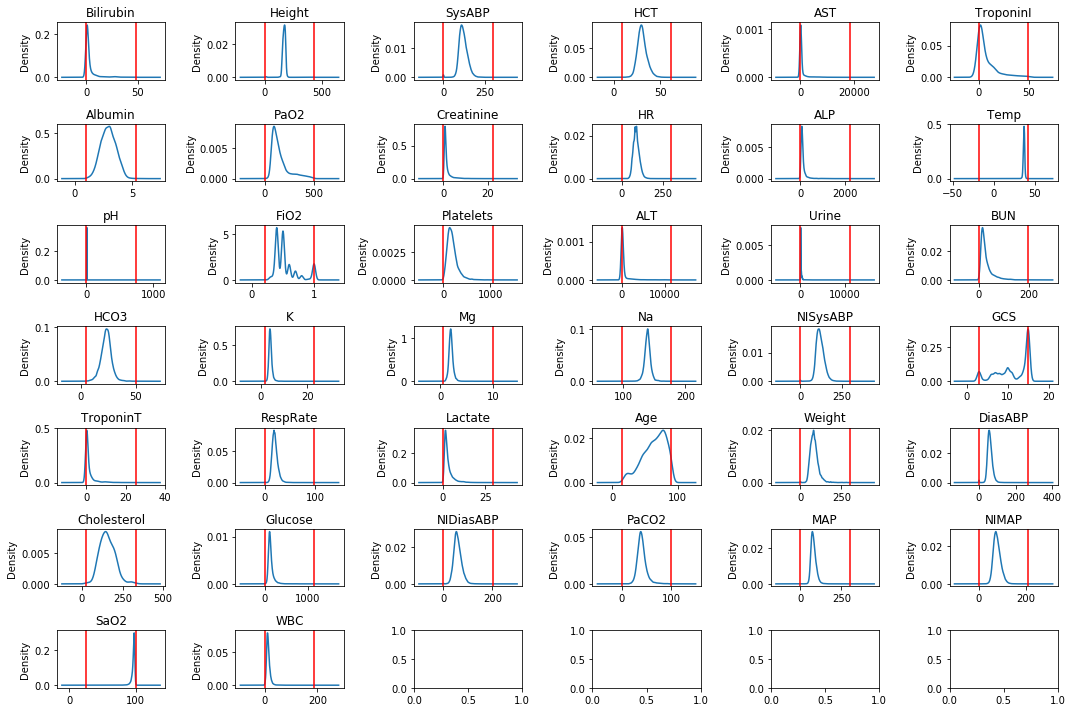

In [26]:
fig, ax = plt.subplots(nrows=7, ncols=6, figsize=(15,10))

# fig.suptitle('Univariate KDE of standardizable variables')

for index, var in enumerate(standardizable_vars):
    
    num_col = index % 6
    num_row = int(index / 6)

    axis = ax[num_row, num_col]
    axis.set_title(var)
    values = seta_data[seta_data['Parameter'] == var]['Value']
    
    values.plot.kde(ax=axis)
    
    axis.axvline(x=values.min(),color='r', label='min')
    axis.axvline(x=values.max(),color='r', label='max')
plt.tight_layout()

After I plotted the KDEs of variables, some things came to mind. 

1. Some variables really do have outliers. For example, see Temp, which is generally around the 36 - 37 range. I would guess that this is in Celsius. However, the min value is -17.8 (about 0 degrees F). The most compatible story with that data point is measurement error of some sort, unless the individual came from a really cold place initially...

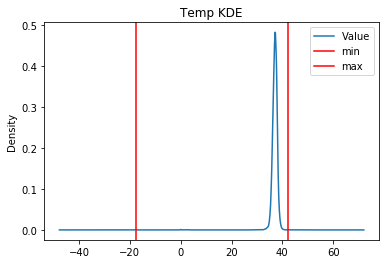

In [27]:
fig, ax = plt.subplots(1,1)
values = seta_data[seta_data['Parameter'] == 'Temp']['Value']
values.plot.kde(title='Temp KDE', ax=ax)
ax.axvline(x=values.min(),color='r', label='min')
ax.axvline(x=values.max(),color='r', label='max')
plt.legend(loc='upper right')

### MechVent is useless

This variable is the same value across all individuals. It does not offer any information extra information about the in-hospital death status of an individual. Therefore we can remove it.

In [28]:
seta_data[seta_data['Parameter'] == 'MechVent'].describe()

,PATIENT_ID,Value,Time_delta,time_block
count,31144.000000,31144.0,31144,31135.000000
mean,137650.676342,1.0,0 days 21:34:38.430516,15.664558
std,2927.235050,0.0,0 days 13:51:45.242087,13.406225
min,132540.000000,1.0,0 days 00:00:00,0.000000
25%,135146.000000,1.0,0 days 09:16:45,0.000000
50%,137678.000000,1.0,0 days 20:16:00,12.000000
75%,140166.000000,1.0,1 days 09:15:00,24.000000
max,142673.000000,1.0,2 days 00:00:00,36.000000


### Create cross-product

In [29]:
index = pd.MultiIndex.from_product(
    [unique_patient_ids, standardizable_vars, list(range(0, 48, WIDTH_HOURS))], 
    names = ["PATIENT_ID", "Parameter", "time_block"]
)

cross_product = pd.DataFrame(index = index).reset_index()
cross_product['Value'] = np.nan

### Merge

In [30]:
merged = pd.merge(left=cross_product, right=reset_averaged, on=['PATIENT_ID', 'Parameter', 'time_block'], how='left')
merged

,PATIENT_ID,Parameter,time_block,Value_x,Value_y
0,132539,Bilirubin,0,NaN,NaN
1,132539,Bilirubin,12,NaN,NaN
2,132539,Bilirubin,24,NaN,NaN
3,132539,Bilirubin,36,NaN,NaN
4,132539,Height,0,NaN,NaN
5,132539,Height,12,NaN,NaN
6,132539,Height,24,NaN,NaN
7,132539,Height,36,NaN,NaN
8,132539,SysABP,0,NaN,NaN
9,132539,SysABP,12,NaN,NaN


In [31]:
for param in standardizable_vars:
    merged.loc[
        (merged['Parameter'] == param) & (merged['Value_y'].isnull()),
        'Value_y'
    ] = seta_data[seta_data['Parameter'] == param]['Value'].mean()

In [32]:
merged['Parameter_hour_block'] = merged['Parameter'] + '_' + (merged['time_block']).astype('str')
merged

,PATIENT_ID,Parameter,time_block,Value_x,Value_y,Parameter_hour_block
0,132539,Bilirubin,0,NaN,2.908555,Bilirubin_0
1,132539,Bilirubin,12,NaN,2.908555,Bilirubin_12
2,132539,Bilirubin,24,NaN,2.908555,Bilirubin_24
3,132539,Bilirubin,36,NaN,2.908555,Bilirubin_36
4,132539,Height,0,NaN,169.787227,Height_0
5,132539,Height,12,NaN,169.787227,Height_12
6,132539,Height,24,NaN,169.787227,Height_24
7,132539,Height,36,NaN,169.787227,Height_36
8,132539,SysABP,0,NaN,118.697899,SysABP_0
9,132539,SysABP,12,NaN,118.697899,SysABP_12


In [33]:
seta_data[seta_data['Parameter'] == 'Troponini'].describe()

,PATIENT_ID,Value,Time_delta,time_block
count,0.0,0.0,0,0.0
mean,NaN,NaN,NaT,NaN
std,NaN,NaN,NaT,NaN
min,NaN,NaN,NaT,NaN
25%,NaN,NaN,NaT,NaN
50%,NaN,NaN,NaT,NaN
75%,NaN,NaN,NaT,NaN
max,NaN,NaN,NaT,NaN


In [34]:
seta_data[seta_data['Parameter'] == 'Glucose'].describe()

,PATIENT_ID,Value,Time_delta,time_block
count,13021.000000,13021.000000,13021,13017.000000
mean,137549.376546,141.509561,0 days 20:54:32.628830,15.296612
std,2927.082519,67.697572,0 days 14:07:24.584699,13.620030
min,132539.000000,10.000000,0 days 00:00:00,0.000000
25%,135006.000000,105.000000,0 days 08:17:00,0.000000
50%,137489.000000,127.000000,0 days 18:44:00,12.000000
75%,140065.000000,157.000000,1 days 09:34:00,24.000000
max,142673.000000,1143.000000,2 days 00:00:00,36.000000


In [35]:
seta_data[seta_data['Parameter'] == 'Temp'].describe()

,PATIENT_ID,Value,Time_delta,time_block
count,86405.000000,86405.000000,86405,86383.000000
mean,137626.043956,37.007651,0 days 21:41:10.502170,15.751988
std,2899.986755,1.775174,0 days 13:49:53.292703,13.444008
min,132539.000000,-17.800000,0 days 00:00:00,0.000000
25%,135103.000000,36.600000,0 days 09:17:00,0.000000
50%,137699.000000,37.100000,0 days 20:21:00,12.000000
75%,140077.000000,37.600000,1 days 09:23:00,24.000000
max,142673.000000,42.100000,2 days 00:00:00,36.000000


In [36]:
def get_predictors(
    df, 
    parameter_time_block_column='Parameter_hour_block', 
    value_column='Value_y', 
    patient_id_col='PATIENT_ID'
):
    unique_param_time_blocks = df[parameter_time_block_column].unique()
    
    collection = df[df[parameter_time_block_column] == unique_param_time_blocks[0]]
    collection[unique_param_time_blocks[0]] = collection[value_column]
    new_collection = collection[[patient_id_col, unique_param_time_blocks[0]]]
    
    for i in range(1, len(unique_param_time_blocks)):
        param_time_block_col = unique_param_time_blocks[i]
        
        data = df[df[parameter_time_block_column] == param_time_block_col].copy()
        data[param_time_block_col] = data[value_column]
        new_collection = pd.merge(
            left=new_collection, 
            right=data[
                [
                    patient_id_col, 
                    param_time_block_col
                ]
            ], 
            on=patient_id_col
        )
        
    return new_collection
        

### flattened_predictors

In [37]:
flattened_predictors = get_predictors(merged)
flattened_predictors

/Users/eddericugaddan/miniconda3/envs/icu-survival/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


,PATIENT_ID,Bilirubin_0,Bilirubin_12,Bilirubin_24,Bilirubin_36,Height_0,Height_12,Height_24,Height_36,SysABP_0,...,NIMAP_24,NIMAP_36,SaO2_0,SaO2_12,SaO2_24,SaO2_36,WBC_0,WBC_12,WBC_24,WBC_36
0,132539,2.908555,2.908555,2.908555,2.908555,169.787227,169.787227,169.787227,169.787227,118.697899,...,66.666667,77.708750,96.637068,96.637068,96.637068,96.637068,11.200000,12.670084,9.400000,12.670084
1,132540,2.908555,2.908555,2.908555,2.908555,175.300000,169.787227,169.787227,169.787227,106.370370,...,80.207500,66.223333,98.000000,97.000000,96.637068,95.000000,7.400000,13.100000,12.670084,13.300000
2,132541,3.000000,2.800000,2.908555,2.908555,169.787227,169.787227,169.787227,169.787227,118.697899,...,92.553333,76.780450,96.637068,95.000000,96.637068,96.637068,4.200000,3.700000,12.670084,6.200000
3,132543,0.200000,2.908555,2.908555,2.908555,180.300000,169.787227,169.787227,169.787227,118.697899,...,80.472500,84.278333,96.637068,96.637068,96.637068,96.637068,10.150000,12.670084,7.900000,12.670084
4,132545,2.908555,2.908555,2.908555,2.908555,169.787227,169.787227,169.787227,169.787227,118.697899,...,76.666000,66.860833,96.637068,96.637068,96.637068,96.637068,3.800000,12.670084,4.800000,12.670084
5,132547,2.908555,0.400000,2.908555,2.908555,180.300000,169.787227,169.787227,169.787227,115.250000,...,76.780450,76.780450,96.000000,97.000000,96.637068,98.000000,24.000000,14.400000,12.670084,13.000000
6,132548,2.908555,2.908555,2.908555,2.908555,162.600000,169.787227,169.787227,169.787227,186.363636,...,76.780450,76.780450,96.637068,96.637068,96.637068,96.637068,6.200000,6.700000,12.670084,6.200000
7,132551,0.300000,2.908555,2.908555,2.908555,162.600000,169.787227,169.787227,169.787227,117.923077,...,57.388333,46.890000,97.000000,94.000000,96.637068,97.000000,18.250000,12.670084,23.500000,12.670084
8,132554,2.908555,2.908555,2.908555,2.908555,169.787227,169.787227,169.787227,169.787227,118.697899,...,86.525000,80.361667,96.637068,96.637068,96.637068,96.637068,12.670084,15.200000,12.670084,12.670084
9,132555,2.908555,2.908555,2.908555,2.908555,175.300000,169.787227,169.787227,169.787227,114.347826,...,76.780450,75.670000,98.000000,96.000000,96.637068,96.637068,9.000000,9.700000,12.670084,11.800000


In [38]:
def merge_categoricals(
    original_source_df,
    left_df,
    patient_id_col='PATIENT_ID',
    categoricals=['Gender', 'ICUType']
):
    df = pd.DataFrame()
    
    for i in categoricals:
        data = original_source_df[original_source_df['Parameter'] == i].copy()
        data[i] = data['Value']
        
        if df.shape[0] == 0:
            df = pd.merge(
                left=left_df,
                right=data[[patient_id_col, i]],
                on=patient_id_col,
                how='left'
            )
            
        else:
            df = pd.merge(
                left=df,
                right=data[[patient_id_col, i]],
                on=patient_id_col,
                how='left'
            )
            
    return df

In [39]:
complete_predictors = merge_categoricals(
    original_source_df=seta_data,
    left_df=flattened_predictors,
)

In [40]:
complete_predictors.columns

Index(['PATIENT_ID', 'Bilirubin_0', 'Bilirubin_12', 'Bilirubin_24',
       'Bilirubin_36', 'Height_0', 'Height_12', 'Height_24', 'Height_36',
       'SysABP_0',
       ...
       'SaO2_0', 'SaO2_12', 'SaO2_24', 'SaO2_36', 'WBC_0', 'WBC_12', 'WBC_24',
       'WBC_36', 'Gender', 'ICUType'],
      dtype='object', length=155)

In [41]:
complete_predictor_cols = complete_predictors.columns[
    ~complete_predictors.columns.str.contains('Age_')
]

### full predictors

In [42]:
predictors = complete_predictors[complete_predictor_cols]
predictors

,PATIENT_ID,Bilirubin_0,Bilirubin_12,Bilirubin_24,Bilirubin_36,Height_0,Height_12,Height_24,Height_36,SysABP_0,...,SaO2_0,SaO2_12,SaO2_24,SaO2_36,WBC_0,WBC_12,WBC_24,WBC_36,Gender,ICUType
0,132539,2.908555,2.908555,2.908555,2.908555,169.787227,169.787227,169.787227,169.787227,118.697899,...,96.637068,96.637068,96.637068,96.637068,11.200000,12.670084,9.400000,12.670084,0.0,4.0
1,132540,2.908555,2.908555,2.908555,2.908555,175.300000,169.787227,169.787227,169.787227,106.370370,...,98.000000,97.000000,96.637068,95.000000,7.400000,13.100000,12.670084,13.300000,1.0,2.0
2,132541,3.000000,2.800000,2.908555,2.908555,169.787227,169.787227,169.787227,169.787227,118.697899,...,96.637068,95.000000,96.637068,96.637068,4.200000,3.700000,12.670084,6.200000,0.0,3.0
3,132543,0.200000,2.908555,2.908555,2.908555,180.300000,169.787227,169.787227,169.787227,118.697899,...,96.637068,96.637068,96.637068,96.637068,10.150000,12.670084,7.900000,12.670084,1.0,3.0
4,132545,2.908555,2.908555,2.908555,2.908555,169.787227,169.787227,169.787227,169.787227,118.697899,...,96.637068,96.637068,96.637068,96.637068,3.800000,12.670084,4.800000,12.670084,0.0,3.0
5,132547,2.908555,0.400000,2.908555,2.908555,180.300000,169.787227,169.787227,169.787227,115.250000,...,96.000000,97.000000,96.637068,98.000000,24.000000,14.400000,12.670084,13.000000,1.0,1.0
6,132548,2.908555,2.908555,2.908555,2.908555,162.600000,169.787227,169.787227,169.787227,186.363636,...,96.637068,96.637068,96.637068,96.637068,6.200000,6.700000,12.670084,6.200000,0.0,3.0
7,132551,0.300000,2.908555,2.908555,2.908555,162.600000,169.787227,169.787227,169.787227,117.923077,...,97.000000,94.000000,96.637068,97.000000,18.250000,12.670084,23.500000,12.670084,0.0,3.0
8,132554,2.908555,2.908555,2.908555,2.908555,169.787227,169.787227,169.787227,169.787227,118.697899,...,96.637068,96.637068,96.637068,96.637068,12.670084,15.200000,12.670084,12.670084,0.0,3.0
9,132555,2.908555,2.908555,2.908555,2.908555,175.300000,169.787227,169.787227,169.787227,114.347826,...,98.000000,96.000000,96.637068,96.637068,9.000000,9.700000,12.670084,11.800000,1.0,2.0


In [43]:
outcomes.columns

Index(['RecordID', 'SAPS-I', 'SOFA', 'Length_of_stay', 'Survival',
       'In-hospital_death'],
      dtype='object')

### predictors and outcome

In [44]:
predictors_and_outcome = pd.merge(
    left=predictors,
    right=outcomes[['RecordID', 'In-hospital_death']],
    left_on='PATIENT_ID',
    right_on='RecordID'
)

In [45]:
predictors_and_outcome.loc[
    predictors_and_outcome['Gender'].isnull(),
    'Gender'
] = np.round(predictors_and_outcome['Gender'].mean())

In [46]:
predictors_and_outcome[complete_predictor_cols].isnull().sum().sum()

0

In [47]:
predictors_and_outcome

,PATIENT_ID,Bilirubin_0,Bilirubin_12,Bilirubin_24,Bilirubin_36,Height_0,Height_12,Height_24,Height_36,SysABP_0,...,SaO2_24,SaO2_36,WBC_0,WBC_12,WBC_24,WBC_36,Gender,ICUType,RecordID,In-hospital_death
0,132539,2.908555,2.908555,2.908555,2.908555,169.787227,169.787227,169.787227,169.787227,118.697899,...,96.637068,96.637068,11.200000,12.670084,9.400000,12.670084,0.0,4.0,132539,0
1,132540,2.908555,2.908555,2.908555,2.908555,175.300000,169.787227,169.787227,169.787227,106.370370,...,96.637068,95.000000,7.400000,13.100000,12.670084,13.300000,1.0,2.0,132540,0
2,132541,3.000000,2.800000,2.908555,2.908555,169.787227,169.787227,169.787227,169.787227,118.697899,...,96.637068,96.637068,4.200000,3.700000,12.670084,6.200000,0.0,3.0,132541,0
3,132543,0.200000,2.908555,2.908555,2.908555,180.300000,169.787227,169.787227,169.787227,118.697899,...,96.637068,96.637068,10.150000,12.670084,7.900000,12.670084,1.0,3.0,132543,0
4,132545,2.908555,2.908555,2.908555,2.908555,169.787227,169.787227,169.787227,169.787227,118.697899,...,96.637068,96.637068,3.800000,12.670084,4.800000,12.670084,0.0,3.0,132545,0
5,132547,2.908555,0.400000,2.908555,2.908555,180.300000,169.787227,169.787227,169.787227,115.250000,...,96.637068,98.000000,24.000000,14.400000,12.670084,13.000000,1.0,1.0,132547,0
6,132548,2.908555,2.908555,2.908555,2.908555,162.600000,169.787227,169.787227,169.787227,186.363636,...,96.637068,96.637068,6.200000,6.700000,12.670084,6.200000,0.0,3.0,132548,0
7,132551,0.300000,2.908555,2.908555,2.908555,162.600000,169.787227,169.787227,169.787227,117.923077,...,96.637068,97.000000,18.250000,12.670084,23.500000,12.670084,0.0,3.0,132551,1
8,132554,2.908555,2.908555,2.908555,2.908555,169.787227,169.787227,169.787227,169.787227,118.697899,...,96.637068,96.637068,12.670084,15.200000,12.670084,12.670084,0.0,3.0,132554,0
9,132555,2.908555,2.908555,2.908555,2.908555,175.300000,169.787227,169.787227,169.787227,114.347826,...,96.637068,96.637068,9.000000,9.700000,12.670084,11.800000,1.0,2.0,132555,0


## Modeling

In [48]:
def strat_k_fold(df, clf, n_splits=5, predictor_cols=complete_predictor_cols, y_column_name='In-hospital_death'):
    X = df[complete_predictor_cols].values
    y = df[y_column_name]
    skf = StratifiedKFold(n_splits=n_splits)

    scores = []

    for train_index, test_index in skf.split(X, y):
        X_test, y_test = X[test_index], y[test_index]
        
        training_data = df.iloc[train_index]
        minority = training_data[training_data[y_column_name] == 1]
        majority = training_data[training_data[y_column_name] == 0]
        
        upsampled_minority = minority.sample(n=majority.shape[0], replace=True)
        
        new_training_df = pd.concat([upsampled_minority, majority])

        # Train the model via upsampling
        clf.fit(new_training_df[predictor_cols].values, new_training_df[y_column_name])

        predict_test = clf.predict(X_test)

        precision = precision_score(y_true=y_test, y_pred=predict_test)
        recall = recall_score(y_true=y_test, y_pred=predict_test)

        scores.append({
            'precision': precision,
            'recall': recall,
            'min_precis_recall': min(precision, recall)
        })
        
    return pd.DataFrame(scores)

In [49]:
rf = strat_k_fold(
    n_splits=5,
    df=predictors_and_outcome,
    clf=RandomForestClassifier(n_estimators=100)
)

In [50]:
strat_k_fold(
    n_splits=5,
    df=predictors_and_outcome,
    clf=AdaBoostClassifier(n_estimators=100)
)

/Users/eddericugaddan/.local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


,min_precis_recall,precision,recall
0,0.000000,0.000000,0.000000
1,0.352041,0.352041,0.621622
2,0.355932,0.355932,0.567568
3,0.312500,0.312500,0.495495
4,0.090909,0.500000,0.090909


In [51]:
gbc = strat_k_fold(
    n_splits=10,
    df=predictors_and_outcome,
    clf=GradientBoostingClassifier(n_estimators=100)
)

In [52]:
gbc

,min_precis_recall,precision,recall
0,0.507042,0.507042,0.642857
1,0.372727,0.372727,0.732143
2,0.356436,0.356436,0.642857
3,0.343750,0.343750,0.589286
4,0.439024,0.439024,0.654545
5,0.354839,0.354839,0.600000
6,0.390805,0.390805,0.618182
7,0.348837,0.348837,0.545455
8,0.428571,0.428571,0.600000
9,0.254545,0.482759,0.254545


In [53]:
gbc['min_precis_recall'].mean()

0.3796576959854435

## Conclusion

With the mean of 0.3716, we were able to surpass the 2012 SAPS-I score of 0.3125. However, we were not able to get in the top-10 list for that year, with the top score being 0.5353. If more time was available, I would look into the relationship of missingness and the outcome. Perhaps, values are not Missing Completely at Random; maybe using the average as the imputed value might be a bad idea.

Also, I could also consider not imputing at all. I read that Gradient Boosted Trees are able to take in data with missing values, and do imputation automatically. That might be another approach to look into. Another thing would be to do more feature engineering -- research the normal values of each variable, and see if observed values are way under or over the expected values.